In [1]:
!pip install tensorflow
!pip install pytorch-pretrained-bert pytorch-nlp

     |████████████████████████████████| 133kB 7.0MB/s 
     |████████████████████████████████| 92kB 6.5MB/s 
     |████████████████████████████████| 133kB 11.1MB/s 
     |████████████████████████████████| 7.6MB 13.5MB/s 
     |████████████████████████████████| 81kB 11.2MB/s 
ERROR: botocore 1.20.98 has requirement urllib3<1.27,>=1.25.4, but you'll have urllib3 1.24.3 which is incompatible.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd ../content/drive/MyDrive/Colab\ Notebooks/jezikProjektFinished

/content/drive/.shortcut-targets-by-id/1_HOFTh3kL_Lx9q7fsvFqh10MNFprRWJx/jezikProjektFinished


In [4]:
outputModelFile = "./model/projektModelFile.bin"
outputConfigFile = "./model/projektConfigFile.bin"

In [5]:
# Dražen
def saveModel(model, outputModelFile, outputConfigFile):
  tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

  modelToSave = model.module if hasattr(model, 'module') else model
  torch.save(modelToSave.state_dict(), outputModelFile)
  modelToSave.config.to_json_file(outputConfigFile)

In [6]:
# Dražen
def loadModel(outputModelFile, outputConfigFile):
  config = BertConfig.from_json_file(outputConfigFile)
  model = BertForSequenceClassification(config, num_labels=3)
  stateDict = torch.load(outputModelFile)
  model.load_state_dict(stateDict)
  return model

In [7]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.python.client import device_lib
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_pretrained_bert import BertModel
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sn
import ipywidgets as widgets
from ipywidgets import Layout
from IPython.display import display

In [8]:
bertTokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

100%|██████████| 231508/231508 [00:00<00:00, 897273.41B/s]


In [9]:
# Antonio
def extractData(path):
    dataFile = pd.read_csv(path, encoding = "ISO-8859-1").to_numpy()
    positiveList = [x for x in dataFile[:,1] if type(x)==str]
    neutralList = [x for x in dataFile[:,2] if type(x)==str]
    negativeList = [x for x in dataFile[:,3] if type(x)==str]
    labels = [0 for x in positiveList] + [1 for x in neutralList] + [2 for x in negativeList]
    allSentences = positiveList + neutralList + negativeList
    return allSentences, labels


In [10]:
# Dražen
def addBertTokensToSent(sent):
  return "[CLS] " + sent + " [SEP]"

In [11]:
# Dražen
def tokenizer(allSentences):
  tokenizedSentences =  [bertTokenizer.tokenize(addBertTokensToSent(sent)) for sent in allSentences]

  return tokenizedSentences

In [12]:
# Dražen
def padding(maxLen, tokenizedText):
  inputForModel = pad_sequences([bertTokenizer.convert_tokens_to_ids(t) for t in tokenizedText], maxlen=maxLen, dtype="long", truncating="post", padding="post")
  inputForModel = [bertTokenizer.convert_tokens_to_ids(t) for t in tokenizedText]
  inputForModel = pad_sequences(inputForModel, maxlen=maxLen, dtype="long", truncating="post", padding="post")
  
  return inputForModel

In [13]:
# Antonio
def ejectingIndexes(tokenizedTexts, labels):
  ejectingIndexes = [i for i in range(len(tokenizedTexts)) if len(tokenizedTexts[i])<=512]
  newTokenizedTexts = [tokenizedTexts[i] for i in ejectingIndexes]
  newLabels = [labels[i] for i in ejectingIndexes]
  
  return newTokenizedTexts, newLabels

In [14]:
# Antonio
def createAttentionMask(modelInput):
  attentionMasks = []
  for s in modelInput:
    seqMask = [float(i>0) for i in s]
    attentionMasks.append(seqMask)
  
  return attentionMasks

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.get_device_name(0)

'Tesla T4'

In [16]:
# Dražen
batchSize = 64
maxLen = 128
numberOfEpoches = 7
learningRate = 2e-5
testSize = 0.1
seed = 1927

path = "translatedData.csv"
allSentences, labels = extractData(path)
tokenizedText = tokenizer(allSentences)
tokenizedText, labels = ejectingIndexes(tokenizedText, labels)
modelInput = padding(maxLen, tokenizedText)
attentionMasks = createAttentionMask(modelInput)

trainInputs, testInputs, trainLabels, testLabels = train_test_split(modelInput, labels, random_state=seed, test_size=testSize)
trainMasks, testMasks, _, _ = train_test_split(attentionMasks, modelInput, random_state=seed, test_size=testSize)

trainInputs = torch.tensor(trainInputs)
testInputs = torch.tensor(testInputs)
trainLabels = torch.tensor(trainLabels)
testLabels = torch.tensor(testLabels)
trainMasks = torch.tensor(trainMasks)
testMasks = torch.tensor(testMasks)

trainData = TensorDataset(trainInputs, trainMasks, trainLabels)
trainSampler = RandomSampler(trainData)
trainDataLoader = DataLoader(trainData, sampler=trainSampler, batch_size=batchSize)
testData = TensorDataset(testInputs, testMasks, testLabels)
testSampler = SequentialSampler(testData)
testDatalLoader = DataLoader(testData, sampler=testSampler, batch_size=batchSize)

In [17]:
# Antonio
def printSentimentDistribution():
  plt.hist(['positive' for x in labels if x==0]+['neutral' for x in labels if x==1]+['negative' for x in labels if x==2])
  plt.xlabel('sentiment')
  plt.ylabel('number of reviews')
  plt.title('sentiment distribution')
  plt.xticks(np.arange(len(np.unique(labels))))
  plt.show()

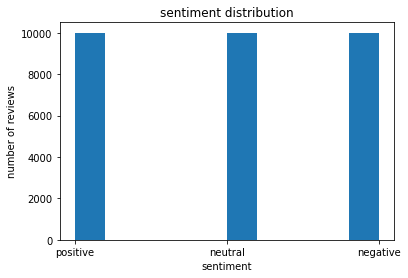

In [ ]:
# Antonio
printSentimentDistribution()

In [18]:
# Antonio
try:
  model = loadModel(outputModelFile, outputConfigFile)
except:
  model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)

model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
   

In [19]:
# Antonio
def accuracy(predictions, labels):
    predFlat = np.argmax(predictions, axis=1).flatten()
    labelsFlat = labels.flatten()
    
    return np.sum(predFlat == labelsFlat) / len(labelsFlat)

In [ ]:
# Dražen
def train(model, learningRate, epochNumber):
  paramOptimizer = list(model.named_parameters())
  no_decay = ['bias', 'gamma', 'beta']
  optimizerGroupedParameters = [
    {'params': [p for n, p in paramOptimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in paramOptimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
  ]

  optimizer = BertAdam(optimizerGroupedParameters, lr=learningRate, warmup=0.1)
  trainLossSet = []
  for i in tqdm(range(epochNumber), desc="Epoch"):
    model.train()
    trainLoss, examplesNumber, stepsNumber = 0, 0, 0 
    
    for step, batch in enumerate(trainDataLoader):
      batch = tuple(b.to(device) for b in batch)
      batchInput, batchInputMask, batchLabels = batch
      optimizer.zero_grad()
      loss = model(batchInput, token_type_ids=None, attention_mask=batchInputMask, labels=batchLabels)
      trainLossSet.append(loss.item())
      loss.backward()
      optimizer.step()
      trainLoss += loss.item()
      examplesNumber += batchInput.size(0)
      stepsNumber += 1
    print("Train loss: {}".format(trainLoss/stepsNumber))
      
    model.eval()
    testLoss, testAccuracy,testExamplesNumber, testStepsNumber,  = 0, 0, 0, 0 
 
    for batch in testDatalLoader:
      batch = tuple(b.to(device) for b in batch)
      batchInput, batchInputMask, batchLabels = batch
      with torch.no_grad():
        logits = model(batchInput, token_type_ids=None, attention_mask=batchInputMask)    
      logits = logits.detach().cpu().numpy()
      outLabel = batchLabels.to('cpu').numpy()
      stepAccuracy = accuracy(logits, outLabel)    
      testAccuracy += stepAccuracy
      testStepsNumber += 1
    print("Validation Accuracy: {}".format(testAccuracy/testStepsNumber))

  plt.figure(figsize=(15,8))
  plt.title("Training loss")
  plt.xlabel("Batch")
  plt.ylabel("Loss")
  plt.plot(trainLossSet)
  plt.show()


t_total value of -1 results in schedule not being applied
Epoch:   0%|          | 0/7 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/pytorch_pretrained_bert/optimization.py:275: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:1025.)
  next_m.mul_(beta1).add_(1 - beta1, grad)


Train loss: 0.6785003724397641


Epoch:  14%|█▍        | 1/7 [11:32<1:09:14, 692.39s/it]

Validation Accuracy: 0.7181784247853676
Train loss: 0.5336371522520391


Epoch:  29%|██▊       | 2/7 [23:15<57:57, 695.58s/it]  

Validation Accuracy: 0.7327652575587906
Train loss: 0.4085918693180898


Epoch:  43%|████▎     | 3/7 [34:58<46:31, 697.77s/it]

Validation Accuracy: 0.7301056830907054
Train loss: 0.2942394915067754


Epoch:  57%|█████▋    | 4/7 [46:41<34:58, 699.42s/it]

Validation Accuracy: 0.7316454367301232
Train loss: 0.21810067633069805


Epoch:  71%|███████▏  | 5/7 [58:24<23:21, 700.62s/it]

Validation Accuracy: 0.7346782848077641
Train loss: 0.17509944125197793


Epoch:  86%|████████▌ | 6/7 [1:10:07<11:41, 701.33s/it]

Validation Accuracy: 0.7374603396789847
Train loss: 0.14906363325608427


Epoch: 100%|██████████| 7/7 [1:21:50<00:00, 701.57s/it]

Validation Accuracy: 0.7350515584173198


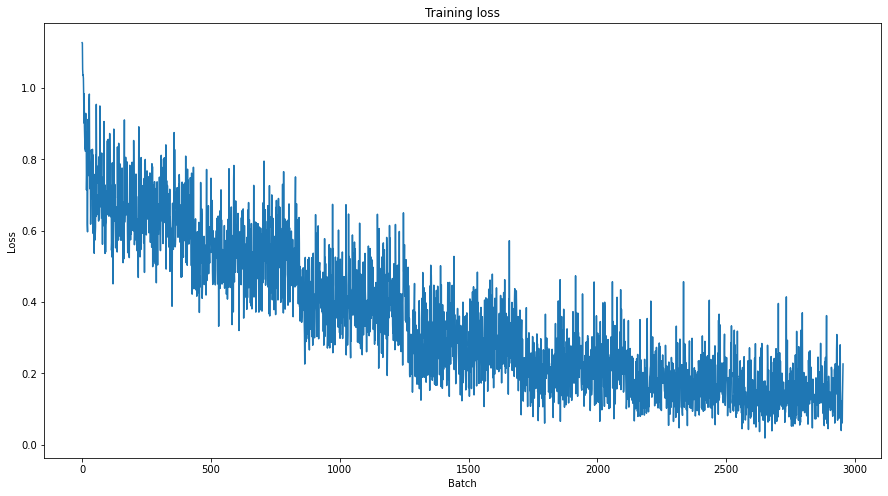

In [ ]:
# Dražen
train(model, learningRate, numberOfEpoches)

In [ ]:
# Anotnio
def test(model, batchSize):
  testDataLoader = DataLoader(testData, sampler=testSampler, batch_size=batchSize)

  model.eval()

  predictions, labels = [], []
 
  for batch in testDataLoader:

    batch = tuple(b.to(device) for b in batch)
    batchInput, batchInputMask, batchLabels = batch

    with torch.no_grad():
      logits = model(batchInput, token_type_ids=None, attention_mask=batchInputMask)
 
    logits = logits.detach().cpu().numpy()
    labelStep = batchLabels.to('cpu').numpy()  
    predictions.append(logits)
    labels.append(labelStep)
    

  flatPredictions = [item for sublist in predictions for item in sublist]
  flatPredictions = np.argmax(flatPredictions, axis=1).flatten()
  flatLabels = [item for sublist in labels for item in sublist]
  
  return flatPredictions, flatLabels, len([i for i in range(len(flatPredictions)) if flatPredictions[i] == flatLabels[i]])/len(flatLabels)


In [ ]:
# Anotnio
flatPredictions, flatLabels, acc = test(model, batchSize)
print(acc)
confusionMatrix = confusion_matrix(flatLabels, flatPredictions)

0.7350883038987004


In [ ]:
# Dražen
def printConfusionMatrix(confusionMatrix, normalised=False):
  df_cm = pd.DataFrame(confusionMatrix, index = ['positive', 'neutral', 'negative'], columns = ['positive', 'neutral', 'negative'])
  plt.figure(figsize = (10,7))
  if(normalised):
    ax = sn.heatmap(df_cm, annot=True, cmap='Blues', fmt='g')
    for t in ax.texts: t.set_text(t.get_text() + " %")
  else:
    sn.heatmap(df_cm, annot=True, cmap='Blues', fmt='g')
  plt.show()

In [ ]:
# Dražen
def normaliseMatrix(confusionMatrix):
  normalisedMatrixConfusion = []
  for i in confusionMatrix:
    rowToAdd = []
    rowSum = sum(i)
    for j in i:
      rowToAdd.append(round(100*j/rowSum,2))
    normalisedMatrixConfusion.append(rowToAdd)
  return normalisedMatrixConfusion

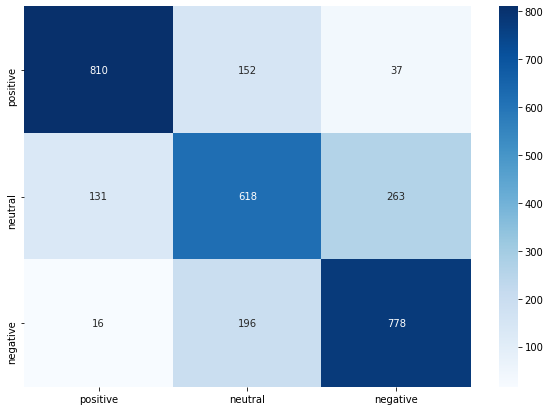

In [ ]:
# Dražen
printConfusionMatrix(confusionMatrix)

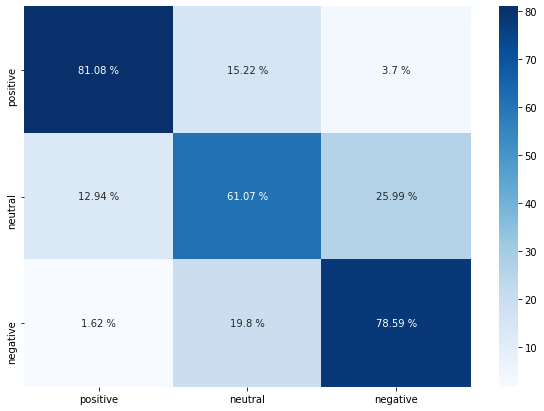

In [ ]:
# Dražen
printConfusionMatrix(normaliseMatrix(confusionMatrix), True)

In [20]:
# Antonio
def predict(sentence, maxLen, batchSize):
  sentence = addBertTokensToSent(sentence)
  tokenizedSentence = tokenizer([sentence])
  modelInput = padding(maxLen, tokenizedSentence)
  attentionMasks = createAttentionMask(modelInput)
  
  testInputs = torch.tensor(modelInput)
  testMasks = torch.tensor(attentionMasks)
  testLabels = torch.tensor([0]) 
  testData = TensorDataset(testInputs, testMasks, testLabels)
  testSampler = SequentialSampler(testData)
  testDataLoader = DataLoader(testData, sampler=testSampler, batch_size=batchSize)
  model.eval()
  predictions = []
  for batch in testDataLoader:
    batch = tuple(b.to(device) for b in batch)
    batchInput, batchInputMask, batchLabels = batch
    with torch.no_grad():
      logits = model(batchInput, token_type_ids=None, attention_mask=batchInputMask)
    logits = logits.detach().cpu().numpy()
    predictions.append(logits)
    result = np.argmax(predictions[0][0])
    if result == 0:
      return 'positive'
    elif result == 1:
      return 'neutral'
    else:
      return 'negative'

In [25]:
# Antonio
def on_button_clicked(b):
  result.value = "Prediction: " + predict(stringToPredict.value, maxLen, batchSize)
  #print(predict(stringToPredict.value, maxLen, batchSize))

In [22]:
# Antonio
stringToPredict = widgets.Textarea(
    value="",
    placeholder='Sentence to predict',
    description='Sentence:',
    disabled=False,
    layout=Layout(width='80%', height='150px')
)
result = widgets.Label("Prediction: ", layout=Layout(margin='0px 0px 0px 25px'))

In [27]:
# Antonio
button = widgets.Button(description="Predict!",layout=Layout(margin='20px 0px 20px 25px'))
button.on_click(on_button_clicked)

In [28]:
display(stringToPredict)
display(button)
display(result)

Textarea(value='sad', description='Sentence:', layout=Layout(height='150px', width='80%'), placeholder='Senten…

Button(description='Predict!', layout=Layout(margin='20px 0px 20px 25px'), style=ButtonStyle())

Label(value='Result: negative', layout=Layout(margin='0px 0px 0px 25px'))

In [ ]:
saveModel(model, outputModelFile, outputConfigFile)